## EECS 731 Project 6
### Adam Podgorny

In [460]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.metrics import classification_report

In [461]:
data = pd.read_csv("rogue_agent_key_updown.csv")

In [462]:
data

,timestamp,value
0,2014-07-06 20:10:00,1.047256
1,2014-07-06 20:15:00,1.848031
2,2014-07-06 20:20:00,1.297892
3,2014-07-06 20:25:00,1.593151
4,2014-07-06 20:35:00,0.000000
...,...,...
5310,2014-07-25 08:35:00,3.751862
5311,2014-07-25 08:40:00,0.000000
5312,2014-07-25 08:45:00,15.505864
5313,2014-07-25 08:50:00,1.397614


So, I think one of the first things we need to consider is the previous value. That will make something like a spike more detectable, and maybe then we can use some Gaussian. Other things that will likely be useful may be Z scores away from the mean (probably zero-ish, but I need to check). IQR may also be applicable, but I want to see where the mean will fall. Reason being, if we have a massively lopsided distribution, as I expect, it may be inappropriate. Really, this will probably be gamma distributed, and it feels like it may be remiss to drop out the zeros so early. 

In [463]:
data['prev'] = 0
t = data['value'].to_list()
a = [0]
for i in range(1,len(t)):
    a.append(t[i-1])

In [464]:
data['prev'] = a

In [465]:
data['prev_2'] = 0
t = data['value'].to_list()
a = [0,0]
for i in range(2,len(t)):
    a.append(t[i-2])
    
data['prev'] = a

data['prev_3'] = 0
a = [0,0,0]
for i in range(3,len(t)):
    a.append(t[i-3])
    
data['prev'] = a

data['last_5_mean'] = 0
a = [0,0,0,0,0]

for i in range(5,len(t)):
    m = []
    for y in range(1,6):
        m.append(t[i-y])
    sm = sum(m)/5.0
    a.append(sm)

data['last_5_mean'] = a

In [466]:
stdev = data['value'].std(ddof=0) #We dont need to do the N-1 divisor, because we have the entire population

In [467]:
mean = data['value'].mean()

In [468]:
mean

0.4882717367253058

In [469]:
stdev

5.370232890037972

In [470]:
data['z'] = data['value'].apply(lambda x: (x - mean)/stdev)

In [471]:
##Some minor forecast style feature analysis
data['date'] = data['timestamp'].apply(lambda x: x.split(" ")[0])
data['time'] = data['timestamp'].apply(lambda x: x.split(" ")[1])
data['dow'] = data['date'].apply(lambda x: pd.Period(x).dayofweek)
data['hour'] = data['time'].apply(lambda x: int(x.split(":")[0]))
data['min'] = data['time'].apply(lambda x: int(x.split(":")[1]))
#data['sec'] = data['time'].apply(lambda x: int(x.split(":")[2])) ##This are minutely updates I believe, as they are all zero

data

,timestamp,value,prev,prev_2,prev_3,last_5_mean,z,date,time,dow,hour,min
0,2014-07-06 20:10:00,1.047256,0.000000,0,0,0.000000,0.104089,2014-07-06,20:10:00,6,20,10
1,2014-07-06 20:15:00,1.848031,0.000000,0,0,0.000000,0.253203,2014-07-06,20:15:00,6,20,15
2,2014-07-06 20:20:00,1.297892,0.000000,0,0,0.000000,0.150761,2014-07-06,20:20:00,6,20,20
3,2014-07-06 20:25:00,1.593151,1.047256,0,0,0.000000,0.205741,2014-07-06,20:25:00,6,20,25
4,2014-07-06 20:35:00,0.000000,1.848031,0,0,0.000000,-0.090922,2014-07-06,20:35:00,6,20,35
...,...,...,...,...,...,...,...,...,...,...,...,...
5310,2014-07-25 08:35:00,3.751862,1.177471,0,0,1.378668,0.607719,2014-07-25,08:35:00,4,8,35
5311,2014-07-25 08:40:00,0.000000,2.992705,0,0,1.983836,-0.090922,2014-07-25,08:40:00,4,8,40
5312,2014-07-25 08:45:00,15.505864,0.992360,0,0,1.782880,2.796451,2014-07-25,08:45:00,4,8,45
5313,2014-07-25 08:50:00,1.397614,3.751862,0,0,4.648558,0.169330,2014-07-25,08:50:00,4,8,50


In [472]:
data = data.drop(['timestamp'], axis=1)

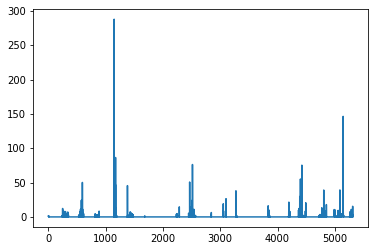

In [473]:
plt.plot(data['value'])

Look at those spikes! That is a lot of key switching. Probably bot of some sort on some of those.

Let's export for some faceting. What I really want to see here is how informative the prior value is

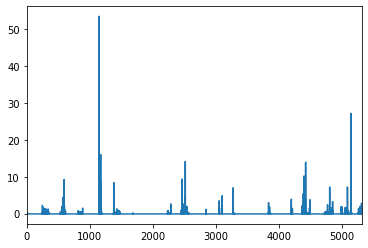

In [474]:
data['z'].plot()

In [475]:
data.to_csv("data.csv") ##Let's export for faceting

In [476]:
data.corr()

,value,prev,prev_2,prev_3,last_5_mean,z,dow,hour,min
value,1.000000,0.021971,NaN,NaN,0.067762,1.000000,-0.024861,0.033181,0.022127
prev,0.021971,1.000000,NaN,NaN,0.493418,0.021971,-0.025155,0.036426,0.011845
prev_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
prev_3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last_5_mean,0.067762,0.493418,NaN,NaN,1.000000,0.067762,-0.052198,0.075309,0.005092
z,1.000000,0.021971,NaN,NaN,0.067762,1.000000,-0.024861,0.033181,0.022127
dow,-0.024861,-0.025155,NaN,NaN,-0.052198,-0.024861,1.000000,0.006955,0.001144
hour,0.033181,0.036426,NaN,NaN,0.075309,0.033181,0.006955,1.000000,-0.000661
min,0.022127,0.011845,NaN,NaN,0.005092,0.022127,0.001144,-0.000661,1.000000


It's easier to see in the facetting screenshots, but there is what appears to be some bias towards later hours for the high keypress events, implying perhaps some sort of nefarious activities when say, hostile foreign powers are at their workdays, or when whatever actors are engaging in such things expect the admins to be sleeping. Although, depending on the nature of the faceting, this only appears to be relative to the Z score itself with respect to time, not the distribution of high value events. That means doing time analysis is likely futile for this, unless I could do a deep ARIMA style projection. Other temporal factors seem evenly distributed

With this in mind, I think Naive Bays may be a useful measure here, since we are looking for events that go over some threshold against the distribution. May try to use Z measures as well. Lastly, I will try isolation forests because they're cool.

In [477]:
from sklearn.naive_bayes import GaussianNB ##I didnt see a Gamma distribution option
from sklearn.ensemble import IsolationForest

Just for a rough idea, lets do some binning!

In [478]:
binned = round(data['z'])

In [479]:
binned.value_counts()

0.0     5189
1.0       66
2.0       30
3.0        8
4.0        6
7.0        3
9.0        3
5.0        2
14.0       2
27.0       1
54.0       1
6.0        1
10.0       1
8.0        1
16.0       1
Name: z, dtype: int64

Look at that distribution. I could be paranoid and say anything above 1 stdev is suspicious, but let's bring some elegance to this.

In [480]:
c = []
g1 = data[data['z'] >= 1]
c.append(len(g1))
g2 = data[data['z'] >= 2]
c.append(len(g2))
g3 = data[data['z'] >= 3]
c.append(len(g3))
g4 = data[data['z'] >= 4]
c.append(len(g4))
g5 = data[data['z'] >= 5]
c.append(len(g5))
g6 = data[data['z'] >= 6]
c.append(len(g6))
g7 = data[data['z'] >= 7]
c.append(len(g7))
g8 = data[data['z'] >= 8]
c.append(len(g8))
g9 = data[data['z'] >= 9]
c.append(len(g9))
g10 = data[data['z'] >= 10]
c.append(len(g10))
g11 = data[data['z'] >= 11]
c.append(len(g11))
g12 = data[data['z'] >= 12]
c.append(len(g12))
g13 = data[data['z'] >= 13]
c.append(len(g13))

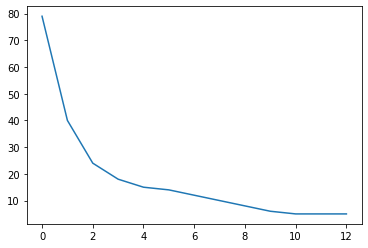

In [481]:
plt.plot(c) ## Z cutoff critera and how many get captured at each

(array([0.85468451, 0.05258126, 0.01147228, 0.00573614, 0.00191205,
        0.00382409, 0.00382409, 0.00382409, 0.00382409, 0.00191205,
        0.        , 0.        , 0.00191205, 0.00191205]),
 array([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 <a list of 14 Patch objects>)

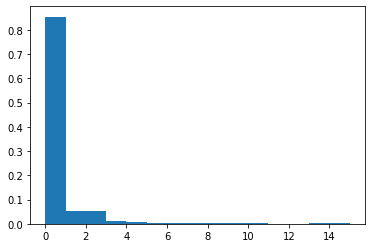

In [482]:
plt.hist(data['z'], bins=[0,1,3,4,5,6,7,8,9,10,11,12,13,14,15], density=True)

There's just one problem here, we don't have a finite definition for what the actual intrusions are, so this really does come down to our thresholds.

Let's try another view

In [483]:
nozeroes = data[data['value'] > 0]

In [484]:
nozeroes

,value,prev,prev_2,prev_3,last_5_mean,z,date,time,dow,hour,min
0,1.047256,0.000000,0,0,0.000000,0.104089,2014-07-06,20:10:00,6,20,10
1,1.848031,0.000000,0,0,0.000000,0.253203,2014-07-06,20:15:00,6,20,15
2,1.297892,0.000000,0,0,0.000000,0.150761,2014-07-06,20:20:00,6,20,20
3,1.593151,1.047256,0,0,0.000000,0.205741,2014-07-06,20:25:00,6,20,25
8,0.899701,0.000000,0,0,0.318630,0.076613,2014-07-06,20:55:00,6,20,55
...,...,...,...,...,...,...,...,...,...,...,...
5308,2.992705,0.726020,0,0,1.846922,0.466355,2014-07-25,08:25:00,4,8,25
5309,0.992360,1.004782,0,0,2.445463,0.093867,2014-07-25,08:30:00,4,8,30
5310,3.751862,1.177471,0,0,1.378668,0.607719,2014-07-25,08:35:00,4,8,35
5312,15.505864,0.992360,0,0,1.782880,2.796451,2014-07-25,08:45:00,4,8,45


In [485]:
nozeroes_mean = nozeroes['value'].mean()
nozeroes_stdev = nozeroes['value'].std()

In [486]:
nozeroes_mean

4.56895119840669

In [487]:
nozeroes_stdev

15.863804391115817

This will probably give a more specific (if maybe less sensitive) basic stat array for the values. Reason being, most entries are zeros, meaning the average is artificially low. There are of course, completely legitimate uses so there may be mini spikes that are just normal use. We want the anomolies that we do detect to be ones that are truly significant, not measured against a zero value, so taking the average of the non zeroes is probably going to normalize the usage a bit in a useful way.

In [488]:
data['normed_z'] = data['value'].apply(lambda x: (x-nozeroes_mean)/nozeroes_stdev)

In [489]:
data

,value,prev,prev_2,prev_3,last_5_mean,z,date,time,dow,hour,min,normed_z
0,1.047256,0.000000,0,0,0.000000,0.104089,2014-07-06,20:10:00,6,20,10,-0.221996
1,1.848031,0.000000,0,0,0.000000,0.253203,2014-07-06,20:15:00,6,20,15,-0.171517
2,1.297892,0.000000,0,0,0.000000,0.150761,2014-07-06,20:20:00,6,20,20,-0.206196
3,1.593151,1.047256,0,0,0.000000,0.205741,2014-07-06,20:25:00,6,20,25,-0.187584
4,0.000000,1.848031,0,0,0.000000,-0.090922,2014-07-06,20:35:00,6,20,35,-0.288011
...,...,...,...,...,...,...,...,...,...,...,...,...
5310,3.751862,1.177471,0,0,1.378668,0.607719,2014-07-25,08:35:00,4,8,35,-0.051507
5311,0.000000,2.992705,0,0,1.983836,-0.090922,2014-07-25,08:40:00,4,8,40,-0.288011
5312,15.505864,0.992360,0,0,1.782880,2.796451,2014-07-25,08:45:00,4,8,45,0.689426
5313,1.397614,3.751862,0,0,4.648558,0.169330,2014-07-25,08:50:00,4,8,50,-0.199910


So let's do the IQR type thing, and make anything greater than 1.0 stdev suspicious. This will be our gold standard. Although...this could also be the model in and of itself, I suppose.

In [490]:
def sus(v):
    if (v >= 1.0):
        return True
    else:
        return False

In [491]:
data['anomaly'] = data['normed_z'].apply(lambda x: sus(x))

In [492]:
data

,value,prev,prev_2,prev_3,last_5_mean,z,date,time,dow,hour,min,normed_z,anomaly
0,1.047256,0.000000,0,0,0.000000,0.104089,2014-07-06,20:10:00,6,20,10,-0.221996,False
1,1.848031,0.000000,0,0,0.000000,0.253203,2014-07-06,20:15:00,6,20,15,-0.171517,False
2,1.297892,0.000000,0,0,0.000000,0.150761,2014-07-06,20:20:00,6,20,20,-0.206196,False
3,1.593151,1.047256,0,0,0.000000,0.205741,2014-07-06,20:25:00,6,20,25,-0.187584,False
4,0.000000,1.848031,0,0,0.000000,-0.090922,2014-07-06,20:35:00,6,20,35,-0.288011,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5310,3.751862,1.177471,0,0,1.378668,0.607719,2014-07-25,08:35:00,4,8,35,-0.051507,False
5311,0.000000,2.992705,0,0,1.983836,-0.090922,2014-07-25,08:40:00,4,8,40,-0.288011,False
5312,15.505864,0.992360,0,0,1.782880,2.796451,2014-07-25,08:45:00,4,8,45,0.689426,False
5313,1.397614,3.751862,0,0,4.648558,0.169330,2014-07-25,08:50:00,4,8,50,-0.199910,False


So this is going to be wierd, since anomolies are so rare. We will need a large enough slice to capture at least a few

In [493]:
label = data['anomaly']
features = data[['value', 'prev', 'dow', 'hour', 'min', 'normed_z', 'z']]
train_x, test_x, train_y, test_y = train_test_split(features, label, random_state=1349, test_size=0.30)

In [494]:
train_y.value_counts()

False    3705
True       15
Name: anomaly, dtype: int64

In [495]:
test_y.value_counts()

False    1589
True        6
Name: anomaly, dtype: int64

In [496]:
##Not ideal, but it's what we have

In [497]:
isolationforest = IsolationForest(500,random_state=1)
isolationforest.fit(train_x, train_y)

IsolationForest(behaviour='deprecated', bootstrap=False, contamination='auto',
                max_features=1.0, max_samples='auto', n_estimators=500,
                n_jobs=None, random_state=1, verbose=0, warm_start=False)

In [498]:
gnb = GaussianNB().fit(train_x, train_y)

In [499]:
if_pred = isolationforest.predict(test_x)
nb_pred = gnb.predict(test_x)

NaiveBayes Scoring

In [500]:
confusion_matrix(test_y, nb_pred)

array([[1562,   27],
       [   0,    6]])

In [501]:
f1_score(test_y, nb_pred)

0.3076923076923077

In [502]:
print(classification_report(test_y, nb_pred, target_names=['normal', 'anomaly']))

              precision    recall  f1-score   support

      normal       1.00      0.98      0.99      1589
     anomaly       0.18      1.00      0.31         6

    accuracy                           0.98      1595
   macro avg       0.59      0.99      0.65      1595
weighted avg       1.00      0.98      0.99      1595



Now, for the Isolation Forest

In [503]:
def recast(x):
    if (x == 1):
        return 0
    if (x==-1):
        return 1

In [504]:
rc_if_pred = pd.Series(if_pred).apply(lambda x: recast(x))

In [505]:
confusion_matrix(test_y, rc_if_pred)

array([[1428,  161],
       [   0,    6]])

In [506]:
print(classification_report(test_y, rc_if_pred, target_names=['normal', 'anomaly']))

              precision    recall  f1-score   support

      normal       1.00      0.90      0.95      1589
     anomaly       0.04      1.00      0.07         6

    accuracy                           0.90      1595
   macro avg       0.52      0.95      0.51      1595
weighted avg       1.00      0.90      0.94      1595



Interestingly, NaiveBayes did a better job in not calling false alarms true alarms. Both did do an excellent job of detection, however, as they had no false negatives. I suppose the Isolation Forest may be a better way of trying to do intrusion detection as it is more paranoid, but using only the features, NB did an overall more accurate job.


I actually tried this at a few z scores of normalized data away, and the result was the same. IF is way more trigger happy with the false positives than NB. This may be due to some factors like feature poisoning, if the temporal value wasn't particular useful. However, the generation algorithms for RFs should be sufficient to address that. I even bumped up the tree number to address that, but to no avail. I had hoped that there would be some clear temporal pattern that emerged, but the faceting didn't really show too much of a crossover except in a slightly trivial way that may have only been a few cases. 

So this is partially an issue with the dataset as well. Anomalies, by definition, are rare data points, and I didn't have a very high pool from which to choose given the dataset we had. I'd have to either artificially create more points, or begin to exclude real normal timepoints that were just low. Doing the latter would create the conditions however where the normal range other values around a no-usage time may appear suspect when they aren't.

I added the last 5 values average feature late in the game, figuring it may help with some trend analysis like the forecasting. It didn't help. I could have likely gotten better value by actually doing a trend analysis line, _then_ casting the projected deviations as anomalies. But there is a better question, since I set the anomaly values myself, ie, greater than some z score, then why not just use that as the alarm value itself and say the IQR model is best fitting? It doesn't feel very elegant, but it seems effective. Had this set been labeled with true rogue actor data, I'd have felt less comfortable with doing things the way I did, but since I can expect all spikes to be suspicious, we can treat those as the true anomalies, meaning our known attack set is anything that produces passes some threshold in the value column.

Of course, changes in the style of data may adjust this. Say a season of high use bumps up the average. That would have to be considered, so such a model would have to frequently be retrained. The collection of more true anomalies would be useful as well for balancing the dataset a bit better. 